# Namespace Affinity

Here we are trying to show that the performance of a local namespace is better than if the namespace is remote.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(300, 400)

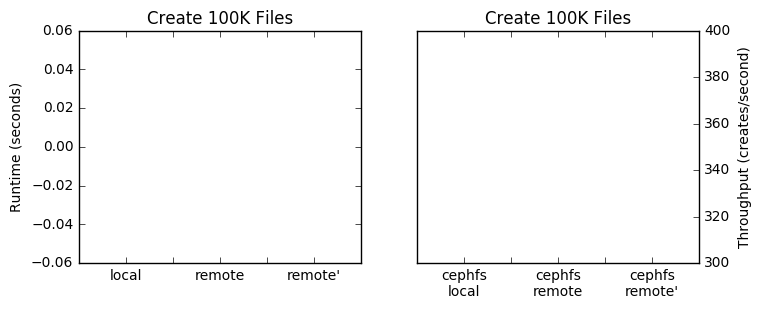

In [2]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def deltas(files):
    r = []
    for f in files:
        with open(f) as data_file:    
            data = json.load(data_file)
            r.append(to_seconds(data['delta']))
    return r
def throughput(files):
    r = []
    for f in files:
        with open(f) as data_file:    
            data = json.load(data_file)
            for line in data['stdout_lines']:
                if "File creation" in line:
                    mean = line.split()[5]
            r.append(float(mean))
    return r

mds0 = deltas(glob.glob('creates/results/mdtest-issdm-12*'))
mds1 = deltas(glob.glob('creates/results/mdtest-issdm-15*'))
mds2 = deltas(glob.glob('creates/results/mdtest-issdm-18*'))

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
ax[0].bar([0.5],
       [np.mean(mds0)],
       yerr=[np.std(mds0)],
       color='blue', ecolor='black', capsize=5)
ax[0].bar([1.5],
       [np.mean(mds1)],
       yerr=[np.std(mds1)],
       color='green', ecolor='black', capsize=5)
ax[0].bar([2.5],
       [np.mean(mds2)],
       yerr=[np.std(mds2)],
       color='red', ecolor='black', capsize=5)
ax[0].set_title("Create 100K Files")
ax[0].set_xticklabels(["", "local", "", "remote", "", "remote\'"])
ax[0].set_ylabel("Runtime (seconds)")
#ax[0].set_ylim(200, 300)

mds0 = throughput(glob.glob('creates/results/mdtest-issdm-12*'))
mds1 = throughput(glob.glob('creates/results/mdtest-issdm-15*'))
mds2 = throughput(glob.glob('creates/results/mdtest-issdm-18*'))

#fig, ax = plt.subplots(figsize=(4,4))
ax[1].bar([0.5, 2.5, 4.5],
       [np.mean(mds0), np.mean(mds1), np.mean(mds2)],
       yerr=[np.std(mds0), np.std(mds1), np.std(mds2)],
       color='red', ecolor='black', capsize=5)
ax[1].set_title("Create 100K Files")
ax[1].set_xticklabels(["", "cephfs\nlocal", "", "cephfs\nremote", "", "cephfs\nremote\'"])
ax[1].set_ylabel("Throughput (creates/second)")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].set_ylim(300, 400)

In [3]:
def run_mean(files):
    i = 0
    rt = pd.DataFrame()
    for fname in files:
        with open(fname) as f:
            df = pd.read_csv(f)
            rt['run' + str(i)] = df['delta'].apply(to_seconds)
            i = i + 1
    rt = rt.drop(rt.index[range(0, 10)])
    return rt.mean(axis=1), rt.std(axis=1)

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

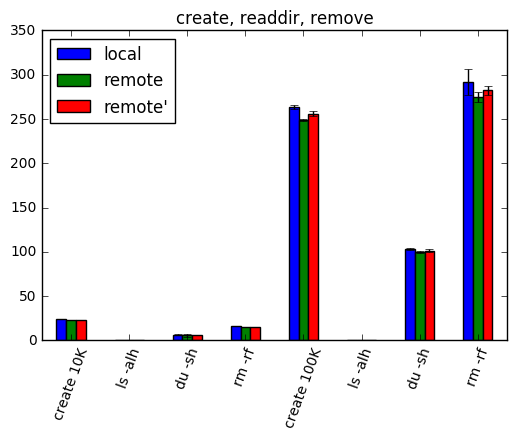

In [4]:
means = pd.DataFrame()
stds = pd.DataFrame()
means['local'], stds['local'] = run_mean(glob.glob('scale/results/scale-issdm-12*'))
means['remote'], stds['remote'] = run_mean(glob.glob('scale/results/scale-issdm-15*'))
means['remote\''], stds['remote\''] = run_mean(glob.glob('scale/results/scale-issdm-18*'))

plt.figure()
ax = means.plot.bar(yerr=stds)
x = ax.set_xticklabels(["create 10K", "ls -alh", "du -sh", "rm -rf",
                        "create 100K", "ls -alh", "du -sh", "rm -rf"])
ax.set_title("create, readdir, remove")
plt.xticks(rotation=70)

         run0        run1        run2
0    5.371774    6.329779    5.410696
1  382.841637  378.139205  378.378861
2   12.977919   13.054403   13.335291
3  589.491759  594.174937  589.182767
4    0.120013    0.109698    0.137821
5  144.362297  144.000901  146.031364
         run0        run1        run2
0    5.312764    5.291974    5.101855
1  377.259133  375.683934  377.882168
2   12.602831   12.826418   12.686840
3  509.568990  511.307743  512.024092
4    0.124709    0.115626    0.112539
5  146.771909  146.694734  146.544101
         run0        run1        run2
0    5.251633    5.405380    5.265630
1  378.486635  379.173264  377.198361
2   12.882354   12.722576   12.769162
3  512.948057  515.062638  514.791647
4    0.124549    0.155506    0.108799
5  148.437755  148.563087  149.087136
         run0        run1        run2        run3
0    4.989452    5.442122    5.247140    5.767475
1   87.415712  109.996956  110.307762  106.326122
2    3.911368    7.410753    5.287404    4.239756
3 

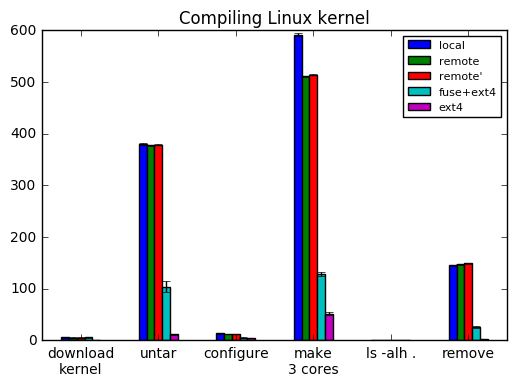

In [5]:
def run_mean(files):
    i = 0
    rt = pd.DataFrame()
    for fname in files:
        with open(fname) as f:
            df = pd.read_csv(f)
            rt['run' + str(i)] = df['delta'].apply(to_seconds)
            i = i + 1
    print rt
    return rt.mean(axis=1), rt.std(axis=1)

means = pd.DataFrame()
stds = pd.DataFrame()
means['local'], stds['local'] = run_mean(glob.glob('compile/results/compile-issdm-12*'))
means['remote'], stds['remote'] = run_mean(glob.glob('compile/results/compile-issdm-15*'))
means['remote\''], stds['remote\''] = run_mean(glob.glob('compile/results/compile-issdm-18*'))
means['fuse+ext4'], stds['fuse+ext4'] = run_mean(glob.glob('experiments/compile-local/results/compile-fuse*'))
means['ext4'], stds['ext4'] = run_mean(glob.glob('experiments/compile-local/results/compile-pl*'))

plt.figure()
ax = means.plot.bar(yerr=stds)
ax.set_xticklabels(["download\nkernel", "untar", "configure", "make\n3 cores", "ls -alh .", "remove"])
plt.xticks(rotation=0)
ax.set_title("Compiling Linux kernel")
x = ax.legend(fontsize=8)

(array([0, 1]), <a list of 2 Text xticklabel objects>)

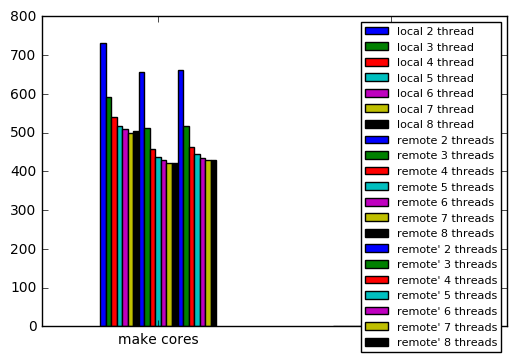

In [6]:
def run_mean(files):
    i = 0
    rt = pd.DataFrame()
    for fname in files:
        with open(fname) as f:
            df = pd.read_csv(f)
            rt['run' + str(i)] = df['delta'].apply(to_seconds)
            i = i + 1
            rt = rt.drop(rt.index[range(0, 3)])
            rt = rt.drop(rt.index[range(2,3)])            
    return rt.mean(axis=1), rt.std(axis=1)

means = pd.DataFrame()
stds = pd.DataFrame()
#means['local 1 thread'], stds['local 1 thread'] = run_mean(glob.glob('compile/results/compile-threads-1-issdm-12-2016-11-28-22:00:37.txt'))
means['local 2 thread'], stds['local 2 threads'] = run_mean(glob.glob('compile/results/compile-threads-2-issdm-12*'))
means['local 3 thread'], stds['local 3 threads'] = run_mean(glob.glob('compile/results/compile-threads-3-issdm-12*'))
means['local 4 thread'], stds['local 4 threads'] = run_mean(glob.glob('compile/results/compile-threads-4-issdm-12*'))
means['local 5 thread'], stds['local 5 threads'] = run_mean(glob.glob('compile/results/compile-threads-5-issdm-12*'))
means['local 6 thread'], stds['local 6 threads'] = run_mean(glob.glob('compile/results/compile-threads-6-issdm-12*'))
means['local 7 thread'], stds['local 7 threads'] = run_mean(glob.glob('compile/results/compile-threads-7-issdm-12*'))
means['local 8 thread'], stds['local 8 threads'] = run_mean(glob.glob('compile/results/compile-threads-8-issdm-12*'))

means['remote 2 threads'], stds['remote 2 threads'] = run_mean(glob.glob('compile/results/compile-threads-2-issdm-15*'))
means['remote 3 threads'], stds['remote 3 threads'] = run_mean(glob.glob('compile/results/compile-threads-3-issdm-15*'))
means['remote 4 threads'], stds['remote 4 threads'] = run_mean(glob.glob('compile/results/compile-threads-4-issdm-15*'))
means['remote 5 threads'], stds['remote 5 threads'] = run_mean(glob.glob('compile/results/compile-threads-5-issdm-15*'))
means['remote 6 threads'], stds['remote 6 threads'] = run_mean(glob.glob('compile/results/compile-threads-6-issdm-15*'))
means['remote 7 threads'], stds['remote 7 threads'] = run_mean(glob.glob('compile/results/compile-threads-7-issdm-15*'))
means['remote 8 threads'], stds['remote 8 threads'] = run_mean(glob.glob('compile/results/compile-threads-8-issdm-15*'))

means['remote\' 2 threads'], stds['remote\' 2 threads'] = run_mean(glob.glob('compile/results/compile-threads-2-issdm-18*'))
means['remote\' 3 threads'], stds['remote\' 3 threads'] = run_mean(glob.glob('compile/results/compile-threads-3-issdm-18*'))
means['remote\' 4 threads'], stds['remote\' 4 threads'] = run_mean(glob.glob('compile/results/compile-threads-4-issdm-18*'))
means['remote\' 5 threads'], stds['remote\' 5 threads'] = run_mean(glob.glob('compile/results/compile-threads-5-issdm-18*'))
means['remote\' 6 threads'], stds['remote\' 6 threads'] = run_mean(glob.glob('compile/results/compile-threads-6-issdm-18*'))
means['remote\' 7 threads'], stds['remote\' 7 threads'] = run_mean(glob.glob('compile/results/compile-threads-7-issdm-18*'))
means['remote\' 8 threads'], stds['remote\' 8 threads'] = run_mean(glob.glob('compile/results/compile-threads-8-issdm-18*'))

plt.figure()
ax = means.plot.bar(yerr=stds)
ax.legend(fontsize=8)
x = ax.set_xticklabels(["make cores"])
plt.xticks(rotation=0)


In [7]:
def run_mean(files):
    i = 0
    rt = pd.DataFrame()
    for fname in files:
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line:
                    start = line.split()[4]
                if "finished" in line:
                    end = line.split()[4]            
            rt['run' + str(i)] = [to_seconds(end) - to_seconds(start)]
            i = i + 1
    return rt.mean(axis=1), rt.std(axis=1)

means = pd.DataFrame()
stds = pd.DataFrame()
means['FUSE'], stds['FUSE'] = run_mean(glob.glob('experiments/droplease-nocache/results/mdtest-100000-issdm-15-*'))
means['FUSE, Cache'], stds['FUSE, Cache'] = run_mean(glob.glob('experiments/droplease-cache/results/mdtest-100000-issdm-15-*'))
means['Kernel'], stds['Kernel'] = run_mean(glob.glob('experiments/kernel/droplease-nocache/results/mdtest-100000*'))
means['Kernel, Cache'], stds['Kernel, Cache'] = run_mean(glob.glob('experiments/kernel/droplease-cache/results/mdtest-100000*'))

ax = means.plot.bar(yerr=stds)
ax.set_title("Create 100K Files")
ax.set_xticklabels([])
plt.xticks(rotation=0)
x = ax.legend(fontsize=8)
ax.set_ylabel("Runtime")

TypeError: Empty 'DataFrame': no numeric data to plot

In [ ]:
def throughput(files):
    r = []
    for f in files:
        with open(f) as data_file:    
            data = json.load(data_file)
            for line in data['stdout_lines']:
                if "File creation" in line:
                    mean = line.split()[5]
            r.append(float(mean))
    print r
    return r

fuse = throughput(glob.glob('experiments/droplease-nocache/results/mdtest-100000-issdm-15-*'))
fusecache = throughput(glob.glob('experiments/droplease-cache/results/mdtest-100000-issdm-15-*'))
kernel = throughput(glob.glob('experiments/kernel/droplease-nocache/results/mdtest-100000*'))
kernelcache = throughput(glob.glob('experiments/kernel/droplease-cache/results/mdtest-100000*'))

#fig, ax = plt.subplots(figsize=(4,4))
ax = plt.subplot()
ax.bar([2.5, 3.5, 4.5, 5.5],
       [np.mean(fuse), np.mean(fusecache), np.mean(kernel), np.mean(kernelcache)],
       yerr=[np.std(fuse), np.std(fusecache), np.std(kernel), np.std(kernelcache)],
       color=['blue', 'green', 'red', 'turquoise'], ecolor='black', capsize=5)
ax.set_title("Create 100K Files")
ax.set_xticklabels(["", "FUSE", "", "FUSE, Cache", "", "Kernel", "", "Kernel\nCache"])
ax.set_ylabel("Throughput (creates/second)")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
